# Keras "Tutorial" Project   
Ruben Pena  
Zach Rosenbaum  
Wesley McGowan  
CS 5841  
Due April 3rd-ish  

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing, model_selection 
from sklearn.metrics import confusion_matrix

import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers, initializers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Check installed versions of tf and keras
print(tf.__version__)
print(keras.__version__)
# Set matplotlib figsize for notebook
plt.rcParams['figure.figsize'] = (10,10)
# Set random seed generator
random.seed(0)

2.2.0-rc2
2.3.0-tf


## Functions

In [0]:
#Creates an oversampled dataset by resampling classes that are below 
#the count_max argument, but above count_min arugement to a certain threshold
def oversample(X,Y,count_min,count_max,threshold):
    classes,counts = np.unique(Y, return_counts=True)
    class_inds = np.where((counts>count_min) & (counts<count_max))[0]
    new_len = np.sum(threshold-counts[class_inds])+len(Y)
    X2 = np.zeros((new_len,X.shape[1]))
    Y2 = np.zeros(new_len)
    X_count = len(X)
    Y_count = len(Y)
    X2[:X_count]=X
    Y2[:Y_count]=Y
    for ind in class_inds:
        C = classes[ind]
        count_diff = threshold-counts[ind]
        np.random.seed(seed=0)
        new_inds = np.random.choice(np.where(Y==C)[0], size=count_diff,replace=True)
        X2[X_count:X_count+count_diff]=X[new_inds]
        Y2[Y_count:Y_count+count_diff]=Y[new_inds]
        X_count+=count_diff
        Y_count+=count_diff
    np.random.seed(seed=0)
    np.random.shuffle(X2)
    np.random.seed(seed=0)
    np.random.shuffle(Y2)
    return X2, Y2

In [0]:
def cv_oob(n, k = 5 , seed = None, shuffle = True):
    if(n<k): return None #a bootstrap based cv should be used if n<k 
    splits = np.zeros((k,n),dtype=bool)
    div = n // k 
    
    #used when k doesn't evenly partition n
    rem = n % k
    bias = 0
    
    #shuffles the (indices of) data
    reindexer = np.arange(n,dtype=int)
    if shuffle:
        np.random.seed(seed=seed)
        np.random.shuffle(reindexer) #uniform random
    for i in range(k):
        ind_star = i * div + bias
        #used when k doesn't evenly partition n
        if rem > 0:
            rem = rem - 1
            bias = bias + 1
        ind_end = (i+1) * div + bias
        #only random if shuffle==true
        random_indices=reindexer[ind_star:ind_end]
        splits[i,random_indices]=True
    return(splits)

#**Question 1-**#


# Introduction - Keras Tutorial for Classifying Wine Quality

The Wine Quality datset was initially developed and used for an acedemic paper which can be found here http://www3.dsi.uminho.pt/pcortez/wine5.pdf

Here they managed to use a multiple regression (MR), neural network (NN), support vector machine (SVM) to create predictive models based on the measured wine features. Here T=.25, T=0.5, and T=1.0 is describing regression tolerance, for the regression classifier. E.g., a predicted quality of 3.49 would be classified as classes within a .5 range if t=.5, so it would be class 3 only. For t=1 each prediction will have 2 classes assiociated with it, so it might be overly generous. 

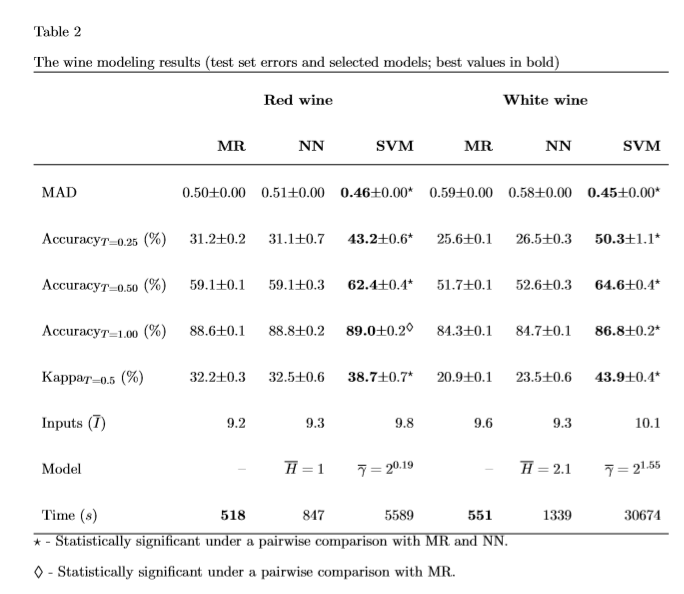

Source: *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

## Objective
For this assignment we'll be working with the **white wine** dataset to classify ***quality*** of the wine, and making comparisons to the Accuracy of the original study(T=.5 row). 

Here they achieved 52.6% on the white wine using a dense layered neural network, and 64.6% using an SVM. Thus, we seek to use these as benchmarks for our accuracy.



# Loading the Data  

Wine quality datasets and column names data were downloaded directly from the UCI Repository using wget() and written into numpy arrays using numpy's built-in load text function.

In [0]:
# '%%capture' is an in-line magic command to squelch output from '!' commands
%%capture 
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv --no-check-certificate #download red wine dataset to colab working directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv --no-check-certificate #download white wine dataset to colab working directory
wine_names = np.loadtxt(open("winequality-red.csv", "rb"), delimiter=";", max_rows=1,dtype=np.unicode_)  #stores column names in numpy char array
wine_names = np.char.strip(wine_names, chars='"') #removes extra quotes from column names
wine_red = np.loadtxt(open("winequality-red.csv", "rb"), delimiter=";", skiprows=1,dtype=np.float64) 
wine_white = np.loadtxt(open("winequality-white.csv", "rb"), delimiter=";", skiprows=1,dtype=np.float64)

## The Dataset  

### *Input Variables* - *physicochemical ratings*     
    1 - fixed acidity  
    2 - volatile acidity  
    3 - citric acid  
    4 - residual sugar  
    5 - chlorides  
    6 - free sulfur dioxide  
    7 - total sulfur dioxide  
    8 - density  
    9 - pH  
    10 - sulphates  
    11 - alcohol  
    

### *Output Variable* - *sensory rating*         
    12 - quality (score between 0 and 10)  



All of the data are imported as continuous values.   

The output variable will need to be transformed to a discrete value as it denotes an ordinal ranking of quality of wine.

## Exploratory Data Analysis  

According to TowardsDataScience: "Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns, to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations."

Below are some common EDA steps taken in a typical data analysis project applied to the Wine Quality Dataset.

In [7]:
# Convert to pandas Dataframe for EDA and view the first five rows of White Wine data to ensure import was successful.
white = pd.DataFrame(data=wine_white,columns=wine_names)
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


The .info() shows that there are no missing values that would require imputation and that the data type for all columns is float64 or continuous.

In [8]:
# check basic info of the White Wine data 
white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


Pandas describe() shows basics summary statistics of the data such as quartiles and standard deviation of the data.

In [0]:
# Summary statistics of White Wine data
white.describe().round(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00,4898.00
mean,6.85,0.28,0.33,6.39,0.05,35.31,138.36,0.99,3.19,0.49,10.51,5.88
std,0.84,0.10,0.12,5.07,0.02,17.01,42.50,0.00,0.15,0.11,1.23,0.89
min,3.80,0.08,0.00,0.60,0.01,2.00,9.00,0.99,2.72,0.22,8.00,3.00
25%,6.30,0.21,0.27,1.70,0.04,23.00,108.00,0.99,3.09,0.41,9.50,5.00
50%,6.80,0.26,0.32,5.20,0.04,34.00,134.00,0.99,3.18,0.47,10.40,6.00
75%,7.30,0.32,0.39,9.90,0.05,46.00,167.00,1.00,3.28,0.55,11.40,6.00
max,14.20,1.10,1.66,65.80,0.35,289.00,440.00,1.04,3.82,1.08,14.20,9.00


Plotting histograms of the dataset will give a graphical display of the distribution of the data. This shows that most of the data is skewed to the right.

It can be observed that quality does in fact consist of discrete values that will need to be transformed during pre-processing. 

Text(0.5, 0.98, 'Histograms of White Wine Data Set')

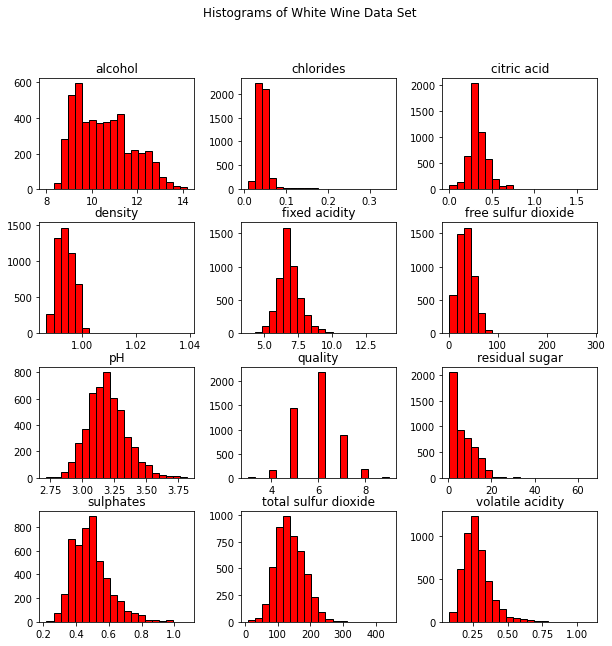

In [9]:
fig1 = white.hist(bins = 20,
                    color = 'red', edgecolor = 'black',
                    linewidth = 1, xlabelsize = 10, ylabelsize = 10,
                    grid=False)
plt.suptitle('Histograms of White Wine Data Set')

There doesn't seem to be any extreme outliers caused by erroneous measurements here, but it should be noted that the scales are very different.

### Scatterplot Matrix
 
A scatterplot matrix for the entire dataset was too large to display and a scaled down version was too difficult to read. 

Instead, scatter plots were divided into two different figures for readability (below).   



Text(0.5, 0.98, 'SPLOM1 of White Wine Dataset')

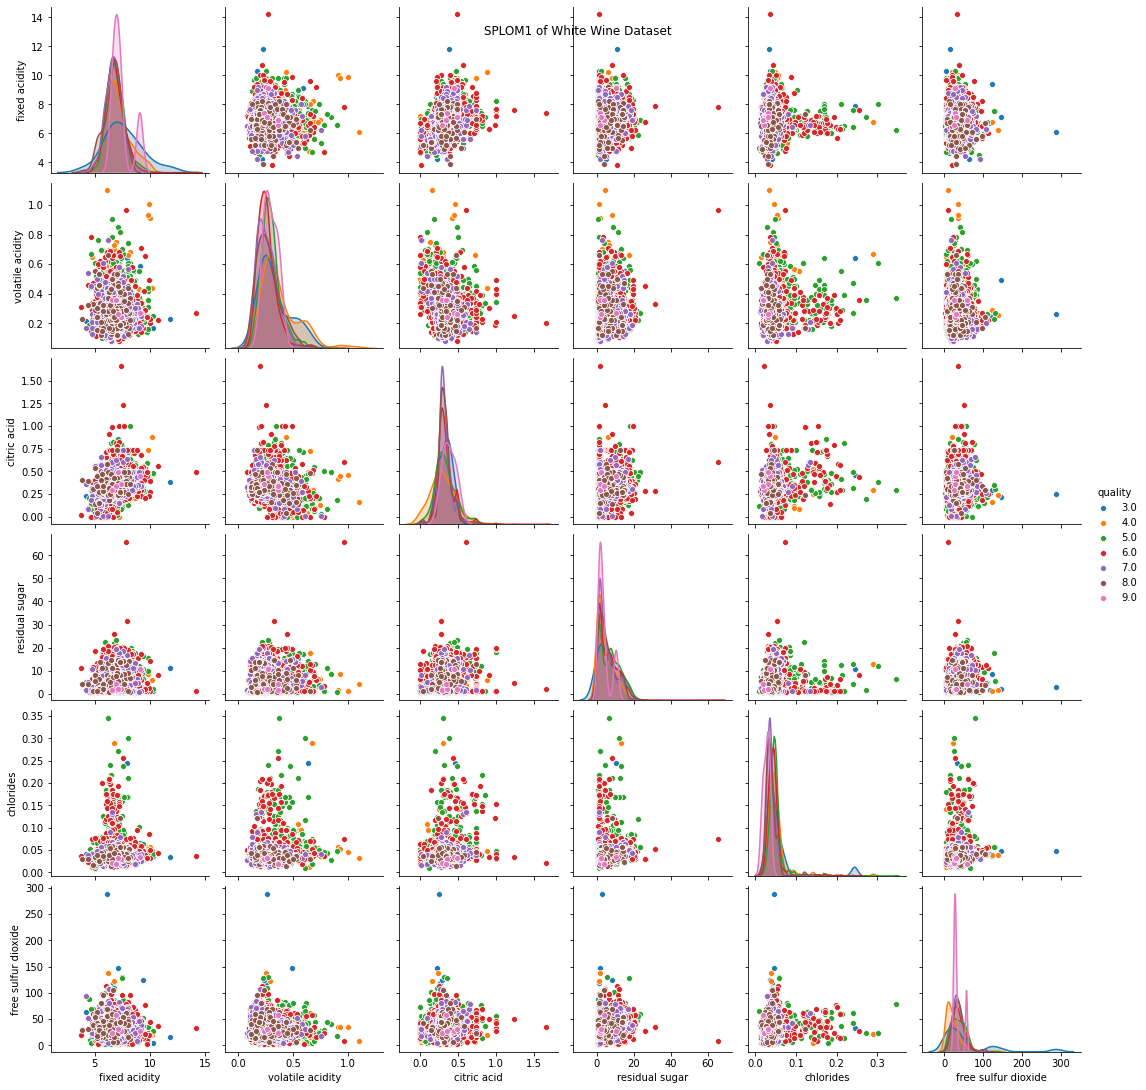

In [10]:
fig2 = sns.pairplot( white, vars = ['fixed acidity', 'volatile acidity', 'citric acid','residual sugar', 'chlorides','free sulfur dioxide'],hue = 'quality')
plt.suptitle('SPLOM1 of White Wine Dataset')

Text(0.5, 0.98, 'SPLOM2 of White Wine Dataset')

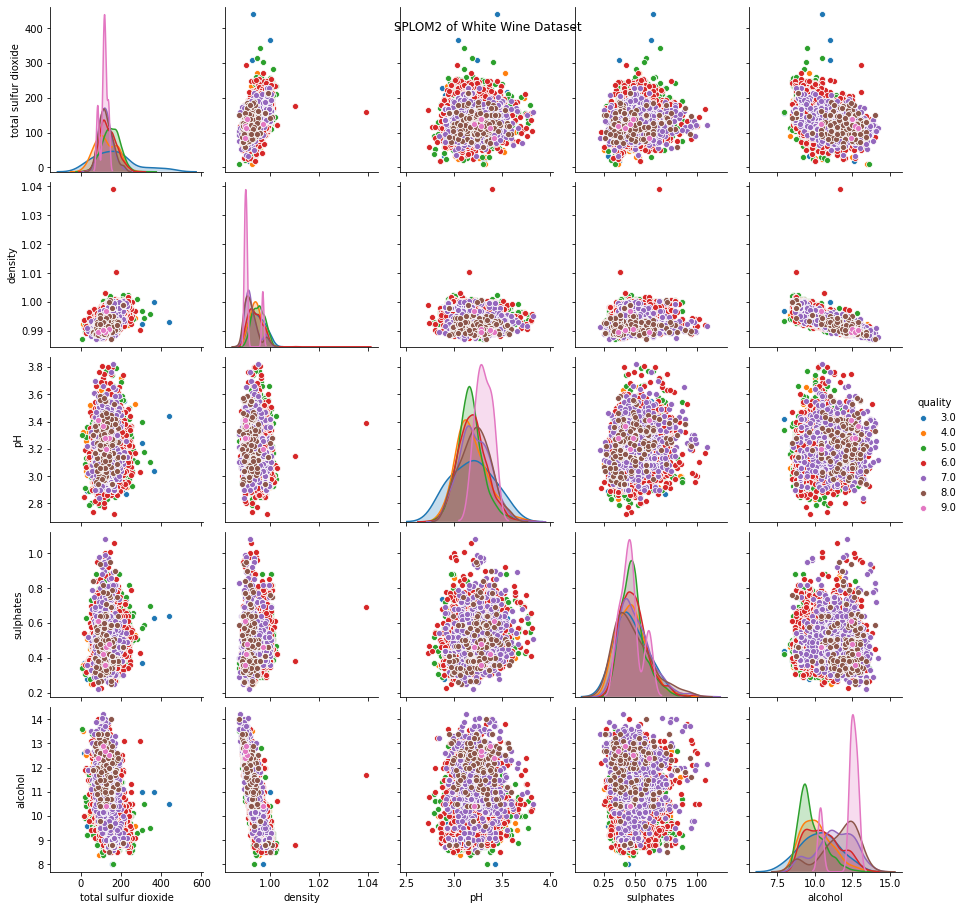

In [11]:
fig3 = sns.pairplot( white, vars = ['total sulfur dioxide','density', 'pH', 'sulphates', 'alcohol'],hue = 'quality')
plt.suptitle('SPLOM2 of White Wine Dataset')

In [0]:
# Full Scatterplot Matrix was analyzed but left out because it was too large to display
#fig4 = sns.pairplot( white,hue = 'quality')
#plt.suptitle('Scatterplot Matrix of White Wine Dataset')

There does not seem to be an obvious linear trends in the data. It will be interesting to see if the neural network's non-linear nature can find something.

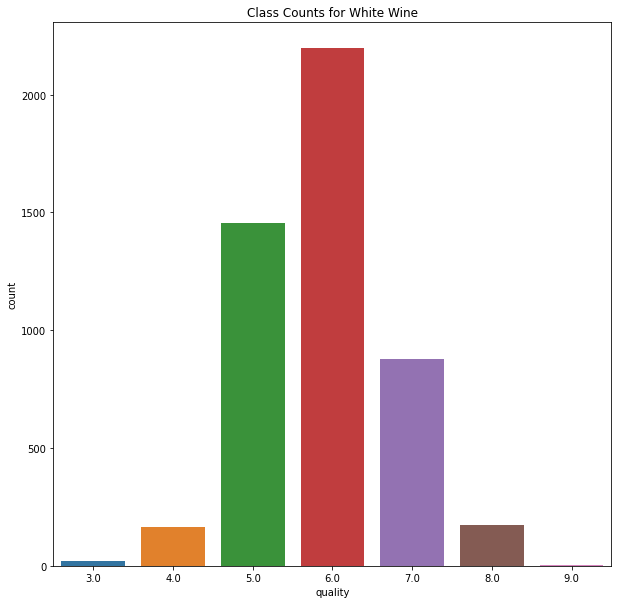

In [12]:
vc_w = sns.countplot(x='quality', data=white).set_title('Class Counts for White Wine') #,ax=ax[0]
plt.show(vc_w)

Significant class imbalance.

Quality ratings of 0, 1, 2, and 10 have 0 occurences.

### Cross Validation Example ###

In bag e.g., the testing data for each fold:

In [13]:
cv_oob(10,k=5,shuffle=False)

array([[ True,  True, False, False, False, False, False, False, False,
        False],
       [False, False,  True,  True, False, False, False, False, False,
        False],
       [False, False, False, False,  True,  True, False, False, False,
        False],
       [False, False, False, False, False, False,  True,  True, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
         True]])

Out of bag e.g., the training data for each fold:

In [14]:
~cv_oob(10,k=5,shuffle=False)

array([[False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True, False, False,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True, False, False,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True, False, False,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False]])

cv_oob is a self written function that returns bool

In [15]:
cv_oob(10,k=5,shuffle=True,seed=0)

array([[False, False,  True, False, False, False, False, False,  True,
        False],
       [False, False, False, False,  True, False, False, False, False,
         True],
       [False,  True, False, False, False, False,  True, False, False,
        False],
       [False, False, False,  True, False, False, False,  True, False,
        False],
       [ True, False, False, False, False,  True, False, False, False,
        False]])

## **Preprocessing**

###Resampling for class imbalance###
The bell-shaped class distribution creates a large class imbalanced, especially classes 3, 4, 8, and 9 which are located in the tails of the curve. This creates an issue when training a neural network as it’s likely to overweight the feature selection of the classes that are represented the most. We tried several different methods to remedy this.  
* Ignoring the class imbalance- We tried ignoring the class imbalance, and this worked OK but classes 3, 4, 8, and 9 were almost never predicted, so we saw it saw it likely that there was room for improvement.
* Loss Weighting - We tried weighting the loss by the ratio of \frac{sample\ size}{observed\ class\ count}, this reduced overall accuracy by 2-3%, and didn’t help the positive prediction rate of class 3 or 9 at all. It did help a bit for 4 and 8 though. We also tried using as a less extreme weight of \sqrt{\frac{sample\ size}{observed\ class\ count}}  which improved the accuracy loss to 1-2%.

* Resampling - 
  >Firstly, we tried creating balanced classes by randomly sampling (with replacement) and adding observations of each class till each class was equally represented, and this didn’t work well as it reduced our overall accuracy by >10%. 
  
  >Secondly, we tried setting a threshold, so that classes below a certain number of observations would be sampled with replacement till they there was 300 observations. This created a neutral result on accuracy, notably classes 4 and 8 had better noticeably better positive predictions rate but classes 3 and 9 still did not see an improvement. 
  
  >At this point we decided that ~15 and ~5 observations that were in the training data simply weren’t numerous enough to be statistically measured in this manner. We considered removing those observations all together but to keep our results on equal footing with the paper’s results we opted to keep them, acknowledging though that these observations were more or less acting as noise. 
 
  >Moving forward, we noted from early that classes 4 and 8 did see positive prediction improvements from the resampling, thus we settled on resampling these observations each up to 200 (each previously had ~100 observations in the training set) but leaving the classes others alone. This resulted in a net increase of .5-1% in overall accuracy, and much higher positive prediction rates for 4 and 8.
Normalization:
Many of our features have a differing scales and distributions. In theory a neural network could learn to scale each feature on its own, but this also would likely require more training epochs. Since we equally value all features thus far, we’ve chosen to normalize by range and standard deviation, in hopes of providing these features to the neural net with equal footing.

###Normalization###
Many of our features have a differing scales and distributions. In theory a neural network could learn to scale each feature on its own, but this also would likely require more training epochs. Since we equally value all features thus far, we’ve chosen to normalize by range and standard deviation, in hopes of providing these features to the neural net with equal footing. In addition most default parameters of neural networks have been chosen with smaller numbers in mind.

In [0]:
# Subset into Predictors and Targets and check shapes
white_x = wine_white[:,0:11]
white_y = wine_white[:,11]


# Stratified 70/30 split on Target
xw_train, xw_test, yw_train, yw_test = model_selection.train_test_split(white_x, white_y,test_size=0.30,random_state=0,stratify=white_y, shuffle=True)

# Classes with oberservation counts between 50 and 200 and resampled to have 200 oberservations
xw_train, yw_train = oversample(xw_train, yw_train, 50, 200, 200) 

# Saves the scaling parameters
scaler = preprocessing.StandardScaler().fit(xw_train)

# Scale the train set by the training set's mean and standard deviation
xw_train = scaler.transform(xw_train)

# Scale the test set by the training set's mean and standard deviation
xw_test = scaler.transform(xw_test)

# Saves yw_test's dense representation for later
y_test = yw_test 

# Converts to a sparse matrix, this is required for the categorical entropy loss function
yw_test=to_categorical(y_test-3, num_classes=7)

# Converts to a sparse matrix, this is required for the categorical entropy loss function
yw_train=to_categorical(yw_train-3, num_classes=7)

In [17]:
# Check shapes of processed data
xw_train.shape,xw_test.shape,yw_train.shape,yw_test.shape

((3592, 11), (1470, 11), (3592, 7), (1470, 7))

#**Question 2 & 3-**#

##**The Model**##
### Some Modelling Decisions ###
* Class imbalance also creates an issue for evaluating model performance, especially with accuracy. If models are chosen by accuracy alone when there’s class imbalance, the class-specific performance for the less common classes will be undervalued or ignored in order to boost accuracy of other more predominant classes. Some more appropriate metrics if one cares about these classes would be F1 or AUC. In the end we chose to focus on overall accuracy because we’re benchmarking our results against the paper which also uses overall accuracy, but we knowningly made this choice.

* The academic paper that we cited earlier choose to bin regression output for predictions. We tried this but found that letting the neural net do the classification for us yielded better results. This was a bit surprising since the qualities are ordinal and thus should also be well predicted by a regression but switching to classification was a pretty consistent +5% increase in accuracy over a variety of test setups.

* While Relu's and Leaky Relu's are extremely popular activation functions right now, they're not as non-linear as functions like sigmoid and tanh. For deep networks this isn't an issue, because the ReLu's small amount of non-linearity have a chance to compound on each other. For shallow networks, like the one we'll be constructing, more computationally expensive activation functions are apprioriate such as sigmoid and tanh.

* We use softmax in the final layer because we wish to create a multinomial distribution which describes the probability of an observation being a certain quality. It should be noted that it wouldn't necessarily make sense to use a softmax in earlier layers as it would constrain them in being positive and adding to one, and this could restrict function approximation process.

* We use a combination of droput and very wide layers (wide in comparison to the dimensionality of the data) in hopes that different parts of each layer will focus in on different feature pathes. 

* After examining SGD, Adam and Adamax we decided on using Adamax. Adam and Adamax were almost identical, and Adamax was generally 0-1% better than SGD. Really any of these yield similar results.

* Adding a regularization term did help a bit, and we'll show an example of tuning our algorithm over this hyperparameter.


### Creating and Compiling the Model

In [0]:
# Create the Model
penalty=0.0001
# tanh is a rescaling of the logistic sigmoid, such that its outputs range from -1 to 1
activation = 'tanh'
# Regularize by dropping out random neurons to prevent overfitting.
dropout = 0.25
model = Sequential()
model.add(Dense(33 , activation=activation , use_bias = 'true', input_dim = 11,kernel_regularizer=regularizers.l2(penalty)))
model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
model.add(Dropout(dropout))
model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
model.add(Dropout(dropout))
model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
model.add(Dropout(dropout))
model.add(Dense(33 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
model.add(Dense(17 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
# finish with the softmax activation function
model.add(Dense(7, activation='softmax'))
#admax optimization works better for sparse data
adamax = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.95, beta_2=0.995)
model.compile(optimizer = adamax, loss = 'categorical_crossentropy', metrics = [categorical_accuracy])

### Visual Representation of the Model

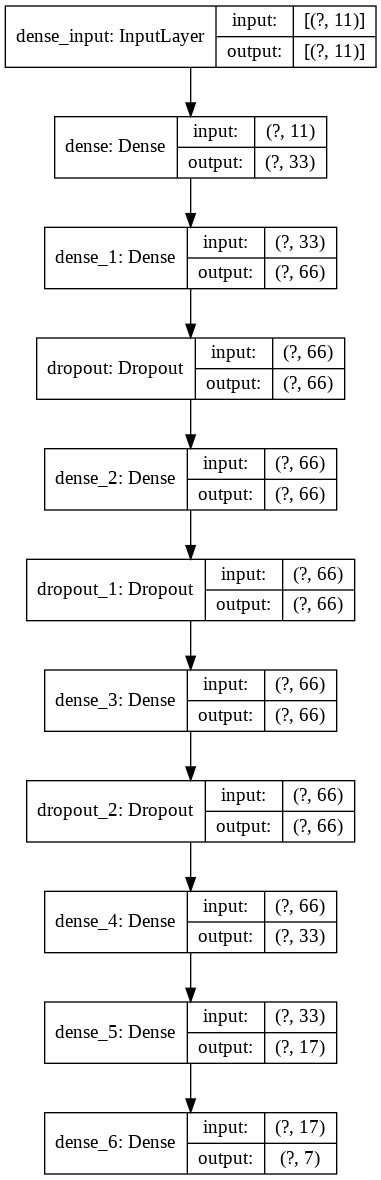

In [20]:
# Visualizing the Model using keras.utils.plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

### Fitting the Model

In [21]:
# Fitting the model
model.fit(xw_train, yw_train, epochs=100, verbose = 0, batch_size = 20 )
acc = model.evaluate(xw_test, yw_test, verbose = 1)
print(acc)

46/46 [==============================] - 0s 1ms/step - loss: 1.0492 - categorical_accuracy: 0.5823
[1.0492486953735352, 0.5823129415512085]


The loss and accuracy for a 100 epoch training on the full training set, evaluated on the test set.

In [22]:
y_pred=(np.argmax(model.predict(xw_test),axis=1)+3)
pd.DataFrame(confusion_matrix(y_test, y_pred),columns=[3,4,5,6,7,8,9],index=[3,4,5,6,7,8,9])

,3,4,5,6,7,8,9
3,0,1,2,3,0,0,0
4,0,12,22,13,2,0,0
5,0,17,264,149,7,0,0
6,0,7,130,473,47,3,0
7,0,3,6,144,104,7,0
8,0,0,0,25,25,3,0
9,0,0,0,0,1,0,0


Without the previous class balancing, the mode would have made almost no guesses for classes 4 and 8. Although this accuracy isn't stellar either, it's better than 0.

In [0]:
def nn_model(X_train, Y_train, X_test, Y_test, penalty=0.0001,activation = 'tanh', droput = 0.25, epochs=25,learning_rate=0.001):
    model = Sequential()
    model.add(Dense(33 , activation=activation , use_bias = 'true', input_dim = 11,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(66 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dropout(dropout))
    model.add(Dense(33 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(17 , activation=activation ,kernel_regularizer=regularizers.l2(penalty)))
    model.add(Dense(7, activation='softmax'))

    adamax = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.95, beta_2=0.995)
    model.compile(optimizer = adamax, loss = 'categorical_crossentropy', metrics = [categorical_accuracy])
    model.fit(X_train, Y_train, epochs=epochs, verbose = 0, batch_size = 20 )
    acc = model.evaluate(X_test, Y_test, verbose = 0)
    return acc

In [24]:
acc = nn_model(xw_train,yw_train,xw_test,yw_test,epochs=100,activation='sigmoid')
print(acc)

[1.3042927980422974, 0.44897958636283875]


The above is an example of the loss, accuracy pair for the same model as above except with sigmoid activation functions for the hidden layers, oddly much worse than tanh.

In [0]:
penalties = [0.001,0.0001,.00001,.000005,.000001,.0000005,.0000001,0.0]

k = 10
oob_fold = cv_oob(len(yw_train),k=k,seed=0)

accs = np.zeros((k,len(penalties)))
losses = np.zeros((k,len(penalties)))


for i in range(k):
    x_ib = xw_train[~oob_fold[i]]
    y_ib = yw_train[~oob_fold[i]]
    x_oob = xw_train[oob_fold[i]]
    y_oob = yw_train[oob_fold[i]]
    for j, penalty in enumerate(penalties):
        losses[i,j], accs[i,j] = nn_model(x_ib, y_ib, x_oob, y_oob, penalty=penalty)


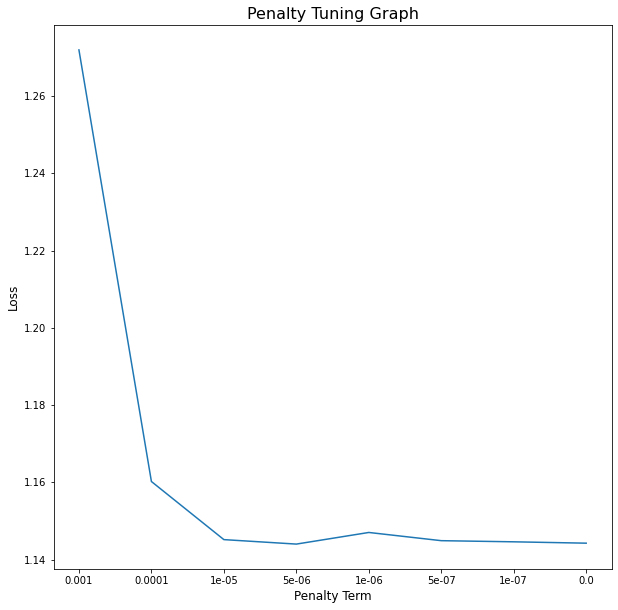

In [0]:
fig = plt.figure()
#fig.suptitle('Penalty Tuning Graph', fontsize=16)
plt.plot(np.mean(losses,axis=0))
plt.title('Penalty Tuning Graph', fontsize=16);
plt.xticks(np.arange(len(penalties)), penalties);
plt.xlabel("Penalty Term", fontsize=12);
plt.ylabel("Loss", fontsize=12);
np.argmin(np.mean(losses,axis=0))


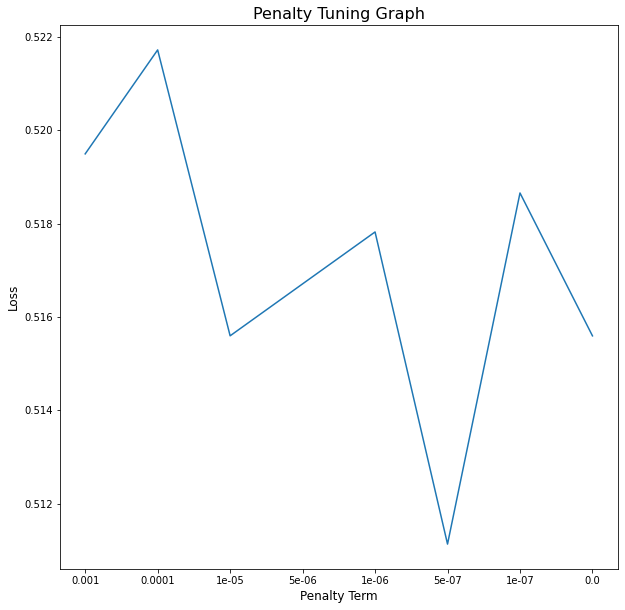

In [0]:
fig = plt.figure()
#fig.suptitle('Penalty Tuning Graph', fontsize=16)
plt.plot(np.mean(accs,axis=0))
plt.title('Penalty Tuning Graph', fontsize=16);
plt.xticks(np.arange(len(penalties)), penalties);
plt.xlabel("Penalty Term", fontsize=12);
plt.ylabel("Accuracy", fontsize=12);

5e-06

In [0]:
""" 

*** If we want to use Red Wine Data ***   
  
# Check shape of npArray for Red Wine data  
 red.shape  

 # Subset into Predictors and Targets and check shapes  
red_x = wine_red[:,0:11]  
red_y = wine_red[:,11]  
red_x.shape,red_y.shape  

# Stratified 70/30 split on Target  
xr_train, xr_test, yr_train, yr_test = model_selection.train_test_split(red_x, red_y,test_size=0.30,random_state=0,stratify=red_y)  

# Check shapes  
xr_train.shape,xr_test.shape,yr_train.shape,yr_test.shape  
# Convert to pandas Dataframe for EDA and check the shape of the Red Wine data
#red = pd.DataFrame(data=wine_red,columns=wine_names)
#red.info()
# View first five rows of Red Wine data
#red.head()
# Summary statistics of Red Wine data
#red.describe()
"""
